## Drawing Trendlines, Support and Resistance

In [1]:
%pip install pandas numpy scipy mplfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Insert number of levels you want to see and minimum touches for trendlines, support and resistance
nb_levels = 1
nb_touches = 3

# Cleaning the data

In [3]:
import pandas as pd
import mplfinance as mpf
import os
import numpy as np
from scipy.signal import argrelextrema

df = pd.read_csv("../Data/BTCUSDT_1h_2.csv")

# Drop last 500 rows 
df = df.tail(5000)

# Convert Unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Find Support Resistance function

In [4]:
def find_support_resistance(df, window=100, num_touches=3, price_threshold=20):
    # Convert DataFrame to numpy array for faster computation
    highs = df['high'].values
    lows = df['low'].values
    volumes = df['volume'].values  # Get volume data
    
    # Calculate rolling mean of volume
    volume_ma = pd.Series(volumes).rolling(window=window, min_periods=1).mean().values
    
    # Find local maxima and minima
    high_idx = argrelextrema(highs, np.greater, order=window)[0]
    low_idx = argrelextrema(lows, np.less, order=window)[0]
    
    # Reverse indices to start from the end
    high_idx = high_idx[::-1]
    low_idx = low_idx[::-1]
    
    # Initialize lists for support and resistance levels with their touch counts and recency
    support_levels = []
    resistance_levels = []
    
    # Find resistance levels (local highs)
    for idx in high_idx:
        level = highs[idx]
        # Count touches for resistance
        touches = np.sum(
            (highs >= level * (1-price_threshold/100)) & 
            (highs <= level * (1+price_threshold/100)) &
            (volumes >= volume_ma)  # Add volume condition
        )
        if touches >= num_touches:
            # Store level with its index (for recency) and touch count
            resistance_levels.append((level, touches, idx))
    
    # Find support levels (local lows)
    for idx in low_idx:
        level = lows[idx]
        # Count touches for support
        touches = np.sum(
            (lows >= level * (1-price_threshold/100)) & 
            (lows <= level * (1+price_threshold/100)) &
            (volumes >= volume_ma)  # Add volume condition
        )
        if touches >= num_touches:
            # Store level with its index (for recency) and touch count
            support_levels.append((level, touches, idx))
    
    # Sort by recency (index) first, then by number of touches
    support_levels.sort(key=lambda x: (-x[1], x[2]))  # Sort by touches (desc) and index (asc)
    resistance_levels.sort(key=lambda x: (-x[1], x[2]))
    
    # Take top n levels and return only the price levels
    return ([x[0] for x in support_levels[:nb_levels]], 
            [x[0] for x in resistance_levels[:nb_levels]])

# Find Trendlines function

In [5]:
def find_multiple_trendlines(df, window=10, min_touches=nb_touches, min_distance=10, max_lines=nb_levels, is_support=True):
    # Get price data based on whether we're looking for support or resistance lines
    prices = df['low'].values if is_support else df['high'].values
    
    # Find local extrema
    if is_support:
        extrema_idx = argrelextrema(prices, np.less, order=window)[0]
    else:
        extrema_idx = argrelextrema(prices, np.greater, order=window)[0]
    
    # Reverse the indices to start from the end
    extrema_idx = extrema_idx[::-1]
    
    trendlines = []
    used_points = set()  # Keep track of points we've used
    valid_lines_count = 0  # Track number of valid lines separately
    
    # Start from the last point and try to find valid trendlines
    for i in range(len(extrema_idx)-1):
        x1 = extrema_idx[i]  # This is the more recent point
        
        if x1 in used_points:
            continue
            
        # Try connecting with previous points
        for j in range(i+1, len(extrema_idx)):
            x2 = extrema_idx[j]  # This is the older point
            
            if x2 in used_points:
                continue
            
            # Skip if points are too close
            if abs(x1 - x2) < min_distance:
                continue
                
            y1, y2 = prices[x1], prices[x2]
            
            # Calculate line parameters (y = mx + b)
            m = (y1 - y2) / (x1 - x2)  # Reversed because x1 is more recent
            b = y1 - m * x1
            
            # Count touches
            touches = 0
            tolerance = 0.01  # 1% tolerance
            
            # Check for touches between the two points
            for k in range(min(x1, x2), max(x1, x2)):
                expected_y = m * k + b
                if abs(prices[k] - expected_y) / expected_y < tolerance:
                    touches += 1
            
            # If we found a valid trendline, check for price crossover
            if touches >= min_touches:
                # Check if any price crosses above/below the line after x1
                valid_line = True
                for k in range(x1, len(prices)):
                    expected_y = m * k + b
                    if is_support and prices[k] < expected_y - expected_y * tolerance:
                        valid_line = False
                        break
                    elif not is_support and prices[k] > expected_y + expected_y * tolerance:
                        valid_line = False
                        break
                
                if valid_line:
                    trendlines.append(((m, b), (x2, x1)))  # Store points in chronological order
                    used_points.add(x1)
                    used_points.add(x2)
                    valid_lines_count += 1
                    break  # Move to next recent point
                
        # If we have enough valid trendlines, stop searching
        if valid_lines_count >= max_lines:
            break
    
    return trendlines

# Plotting 

c:\Users\33668\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


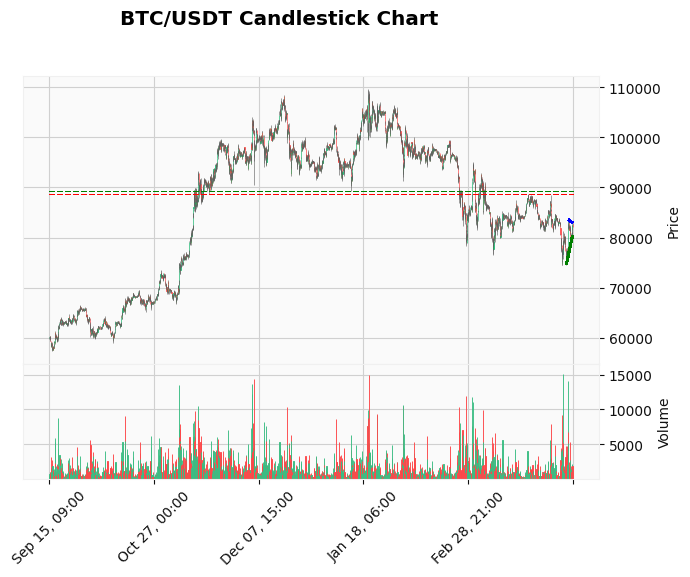

In [6]:
support_levels, resistance_levels = find_support_resistance(df)
# support_levels = []
# resistance_levels = []

# Find both bottom and top trendlines
bottom_trendlines = find_multiple_trendlines(df, is_support=True)
top_trendlines = find_multiple_trendlines(df, is_support=False)

# Prepare plot
kwargs = dict(type='candle', volume=True, title='BTC/USDT Candlestick Chart', style='yahoo')

# Add support and resistance levels with different colors
if support_levels or resistance_levels:
    hlines = []
    colors = []
    
    # Add support levels (green)
    hlines.extend(support_levels)
    colors.extend(['g' for _ in support_levels])
    
    # Add resistance levels (red)
    hlines.extend(resistance_levels)
    colors.extend(['r' for _ in resistance_levels])
    
    if hlines:
        kwargs['hlines'] = dict(hlines=hlines, colors=colors, linestyle='--', linewidths=1)

# Add trendlines if found
alines = []
colors = []

# Get the last index for extending lines
last_idx = len(df) - 1

# Add bottom trendlines (green)
for trendline, points in bottom_trendlines:
    m, b = trendline
    x1, x2 = points
    y1 = m * x1 + b
    # Extend to the right edge of the chart
    y_end = m * last_idx + b
    alines.append([(df.index[x1], y1), (df.index[last_idx], y_end)])
    colors.append('g')

# Add top trendlines (blue)
for trendline, points in top_trendlines:
    m, b = trendline
    x1, x2 = points
    y1 = m * x1 + b
    # Extend to the right edge of the chart
    y_end = m * last_idx + b
    alines.append([(df.index[x1], y1), (df.index[last_idx], y_end)])
    colors.append('b')

if alines:
    kwargs['alines'] = dict(alines=alines, colors=colors)

# Plot the chart with all elements
mpf.plot(df, **kwargs)



# Strategy's code

# Install & Import dependencies

In [7]:
%pip install matplotlib pathos IPython


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathos.multiprocessing import ProcessingPool as Pool



# Load Data

In [9]:
backtesting_years = 4


In [10]:
def load_and_prepare_data(file_path, lookback_days=365):
    """
    Loads data from a CSV file, converts timestamp, sets index,
    and filters for the specified lookback period.
    """
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    if 'Close' in df.columns and 'close' not in df.columns:
        df.rename(columns={'Close': 'close'}, inplace=True)
    elif 'price' in df.columns and 'close' not in df.columns:
        df.rename(columns={'price': 'close'}, inplace=True)
    elif 'Price' in df.columns and 'close' not in df.columns:
        df.rename(columns={'Price': 'close'}, inplace=True)

    end_date = df.index.max()
    start_date = end_date - pd.Timedelta(days=lookback_days)
    df_filtered = df[df.index >= start_date].copy()
    return df_filtered

data_df = load_and_prepare_data("../Data/BTCUSDT_1h_2.csv", lookback_days=365*backtesting_years)



# Strategy Function

In [11]:
# EDITABLE PARAMETERS

# Using by default the best parameters found by optimization
sma_short_period = 35
sma_long_period = 450
initial_capital_value = 10000
position_size_frac = 0.5
SL = 100
TP = 0

In [12]:
def calculate_moving_averages(df, short_window=75, long_window=200):
    """
    Calculates short and long Simple Moving Averages.
    """
    df.loc[:, f'SMA{short_window}'] = df['close'].rolling(window=short_window).mean()
    df.loc[:, f'SMA{long_window}'] = df['close'].rolling(window=long_window).mean()
    return df

data_df_ma = calculate_moving_averages(data_df, short_window=sma_short_period, long_window=sma_long_period)
data_df_ma.dropna(inplace=True)

if data_df_ma.empty:
    print("DataFrame is empty after MA calculation, cannot backtest.")
else:
    print(f"Data loaded for MA Crossover. Shape: {data_df_ma.shape}")


Data loaded for MA Crossover. Shape: (34616, 12)


# Backtesting Function

In [13]:
def backtest_ma_crossover_strategy(df, short_sma_col, long_sma_col, initial_capital, position_size_fraction, sl_amount, tp_amount):
    """
    Backtests the MA Crossover strategy with Stop Loss and Take Profit.
    - Buy when short SMA crosses above long SMA.
    - Sell when short SMA crosses below long SMA or when SL/TP is hit.
    - SL and TP are in dollar amounts from entry price.
    Only one long position at a time.
    """
    capital = initial_capital
    in_position = False
    entry_price = 0
    shares_held = 0
    trades_log = []
    profit_points = []
    current_trade_cost = 0
    sl_price = 0
    tp_price = 0

    # Ensure columns exist
    if short_sma_col not in df.columns or long_sma_col not in df.columns:
        print(f"Error: SMA columns ('{short_sma_col}' or '{long_sma_col}') not found in DataFrame.")
        return [], capital

    # We need a previous state to detect a crossover, so we start from the second available row
    for i in range(1, len(df)):
        current_short_sma = df[short_sma_col].iloc[i]
        current_long_sma = df[long_sma_col].iloc[i]
        prev_short_sma = df[short_sma_col].iloc[i-1]
        prev_long_sma = df[long_sma_col].iloc[i-1]
        current_price = df['close'].iloc[i]
        current_timestamp = df.index[i]

        # Check for SL/TP if in position
        if in_position:
            # Check if SL is hit
            if sl_amount > 0 and current_price <= sl_price:
                proceeds = sl_price * shares_held  # Use SL price for calculation
                profit = proceeds - (entry_price * shares_held) - current_trade_cost
                capital += proceeds

                trades_log.append({
                    'type': 'SELL',
                    'entry_price': round(entry_price, 2),
                    'exit_price': round(sl_price, 2),
                    'shares': round(shares_held, 5),
                    'profit': round(profit, 2),
                    'capital_after_exit': round(capital, 2),
                    'timestamp': current_timestamp,
                    'exit_reason': 'Stop Loss'
                })
                in_position = False
                entry_price = 0
                shares_held = 0
                profit_points.append(profit)
                current_trade_cost = 0
                continue

            # Check if TP is hit
            if tp_amount > 0 and current_price >= tp_price:
                proceeds = tp_price * shares_held  # Use TP price for calculation
                profit = proceeds - (entry_price * shares_held) - current_trade_cost
                capital += proceeds

                trades_log.append({
                    'type': 'SELL',
                    'entry_price': round(entry_price, 2),
                    'exit_price': round(tp_price, 2),
                    'shares': round(shares_held, 5),
                    'profit': round(profit, 2),
                    'capital_after_exit': round(capital, 2),
                    'timestamp': current_timestamp,
                    'exit_reason': 'Take Profit'
                })
                in_position = False
                entry_price = 0
                shares_held = 0
                profit_points.append(profit)
                current_trade_cost = 0
                continue

        # Buy Signal: Short SMA crosses above Long SMA
        if prev_short_sma <= prev_long_sma and current_short_sma > current_long_sma:
            if not in_position:
                if capital <= 0: continue
                investment_amount = capital * position_size_fraction
                leverage = investment_amount / capital
                shares_to_buy = investment_amount / current_price
                
                entry_price = current_price
                shares_held = shares_to_buy
                current_trade_cost = 0.00325 * investment_amount
                capital -= (investment_amount + current_trade_cost)
                in_position = True

                # Set SL and TP prices
                sl_price = entry_price - sl_amount if sl_amount > 0 else 0
                tp_price = entry_price + tp_amount if tp_amount > 0 else float('inf')

                trades_log.append({
                    'type': 'BUY',
                    'price': round(current_price, 2),
                    'shares': round(shares_held, 5),
                    'capital_after_entry': round(capital, 2),
                    'timestamp': current_timestamp,
                    'leverage': leverage,
                    'sl_price': round(sl_price, 2) if sl_amount > 0 else None,
                    'tp_price': round(tp_price, 2) if tp_amount > 0 else None
                })

        # Sell Signal: Short SMA crosses below Long SMA
        elif prev_short_sma >= prev_long_sma and current_short_sma < current_long_sma:
            if in_position:
                proceeds = current_price * shares_held
                profit = proceeds - (entry_price * shares_held) - current_trade_cost
                capital += proceeds
                
                trades_log.append({
                    'type': 'SELL',
                    'entry_price': round(entry_price, 2),
                    'exit_price': round(current_price, 2),
                    'shares': round(shares_held, 5),
                    'profit': round(profit, 2),
                    'capital_after_exit': round(capital, 2),
                    'timestamp': current_timestamp,
                    'exit_reason': 'MA Crossover'
                })
                in_position = False
                entry_price = 0
                shares_held = 0
                profit_points.append(profit)
                current_trade_cost = 0

    return trades_log, capital, profit_points



short_col_name = f'SMA{sma_short_period}'
long_col_name = f'SMA{sma_long_period}'

trades, final_cap, profit_points = backtest_ma_crossover_strategy(data_df_ma, 
                                                short_sma_col=short_col_name, 
                                                long_sma_col=long_col_name,
                                                initial_capital=initial_capital_value,
                                                position_size_fraction=position_size_frac,
                                                sl_amount=SL,
                                                tp_amount=TP)
            

# Printing Results

In [14]:
def calculate_performance_metrics(profit_points, trades, final_capital, initial_capital):
    """Calculate various performance metrics for the strategy"""
    if not profit_points or not trades:
        return None
        
    # Convert to numpy array for calculations
    returns = np.array(profit_points)
    
    # Basic metrics
    total_return = ((final_capital - initial_capital) / initial_capital) * 100
    num_trades = len([t for t in trades if "profit" in t])
    winning_trades = [t['profit'] for t in trades if "profit" in t and t['profit'] > 0]
    losing_trades = [t['profit'] for t in trades if "profit" in t and t['profit'] < 0]
    
    # Win rate and profit metrics
    win_rate = (len(winning_trades) / num_trades * 100) if num_trades > 0 else 0
    avg_win = np.mean(winning_trades) if winning_trades else 0
    avg_loss = np.mean(losing_trades) if losing_trades else 0
    largest_win = max(winning_trades) if winning_trades else 0
    largest_loss = min(losing_trades) if losing_trades else 0
    
    # Risk metrics
    returns_std = np.std(returns) * np.sqrt(252)  # Annualized volatility
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    
    # Sharpe & Sortino Ratios (assuming 0% risk-free rate for simplicity)
    mean_return = np.mean(returns)
    annualized_return = mean_return * 252
    sharpe_ratio = annualized_return / returns_std if returns_std != 0 else 0
    sortino_ratio = annualized_return / downside_std if downside_std != 0 else 0
    
    # Maximum Drawdown
    cumulative_returns = np.cumsum(returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = cumulative_returns - running_max
    max_drawdown = abs(min(drawdowns)) if len(drawdowns) > 0 else 0
    
    # Profit Factor
    gross_profits = sum(winning_trades) if winning_trades else 0
    gross_losses = abs(sum(losing_trades)) if losing_trades else 0.0001
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
    
    # Average trade metrics
    avg_trade = np.mean(returns) if len(returns) > 0 else 0
    
    # Risk-Reward Ratio
    risk_reward_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
    
    return {
        'total_return': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'largest_win': largest_win,
        'largest_loss': largest_loss,
        'profit_factor': profit_factor,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'risk_reward_ratio': risk_reward_ratio,
        'avg_trade': avg_trade,
        'annualized_return': annualized_return,
        'annualized_volatility': returns_std
    }

In [15]:
def print_ma_results(trades, final_capital, initial_capital=10000):
    """Print detailed backtest results including various performance metrics"""
    print("\n=== Strategy Backtest Results ===")
    if not trades:
        print("No trades were executed.")
        print(f"Final Capital: ${final_capital:.2f}")
        return

    # Calculate profit points from trades
    profit_points = [trade['profit'] for trade in trades if "profit" in trade]
    
    # Calculate all performance metrics
    metrics = calculate_performance_metrics(profit_points, trades, final_capital, initial_capital)
    
    if not metrics:
        print("Could not calculate performance metrics.")
        return
        
    # Print Results in organized sections
    print("\n--- Capital and Returns ---")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total Return: {metrics['total_return']:,.2f}%")
    print(f"Annualized Return: {metrics['annualized_return']*100:,.2f}%")
    print(f"Annualized Volatility: {metrics['annualized_volatility']*100:,.2f}%")
    
    print("\n--- Trade Statistics ---")
    print(f"Total Number of Trades: {metrics['num_trades']}")
    print(f"Win Rate: {metrics['win_rate']:.2f}%")
    print(f"Average Trade: ${metrics['avg_trade']:,.2f}")
    print(f"Average Winning Trade: ${metrics['avg_win']:,.2f}")
    print(f"Average Losing Trade: ${metrics['avg_loss']:,.2f}")
    print(f"Largest Winning Trade: ${metrics['largest_win']:,.2f}")
    print(f"Largest Losing Trade: ${metrics['largest_loss']:,.2f}")
    
    print("\n--- Risk Metrics ---")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Sortino Ratio: {metrics['sortino_ratio']:.2f}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']*100:.2f}%")
    print(f"Profit Factor: {metrics['profit_factor']:.2f}")
    print(f"Risk-Reward Ratio: {metrics['risk_reward_ratio']:.2f}")
    
    # Print trade distribution
    print("\n--- Trade Distribution ---")
    profit_trades = len([t for t in trades if "profit" in t and t['profit'] > 0])
    loss_trades = len([t for t in trades if "profit" in t and t['profit'] < 0])
    breakeven_trades = len([t for t in trades if "profit" in t and t['profit'] == 0])
    
    print(f"Profitable Trades: {profit_trades}")
    print(f"Losing Trades: {loss_trades}")
    print(f"Breakeven Trades: {breakeven_trades}")

results = print_ma_results(trades, final_cap, initial_capital=initial_capital_value)
results



=== Strategy Backtest Results ===

--- Capital and Returns ---
Initial Capital: $10,000.00
Final Capital: $17,076.91
Total Return: 70.77%
Annualized Return: 2,511,794.03%
Annualized Volatility: 788,053.38%

--- Trade Statistics ---
Total Number of Trades: 71
Win Rate: 14.08%
Average Trade: $99.67
Average Winning Trade: $928.97
Average Losing Trade: $-36.28
Largest Winning Trade: $2,634.56
Largest Losing Trade: $-50.60

--- Risk Metrics ---
Sharpe Ratio: 3.19
Sortino Ratio: 284.13
Maximum Drawdown: 93333.00%
Profit Factor: 4.20
Risk-Reward Ratio: 25.61

--- Trade Distribution ---
Profitable Trades: 10
Losing Trades: 61
Breakeven Trades: 0


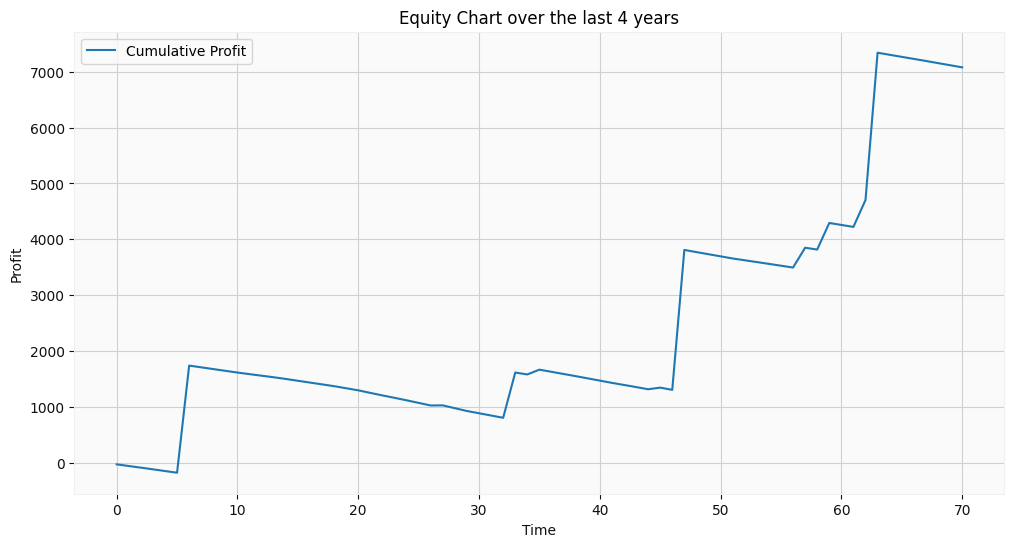

In [16]:
def draw_equity_chart(profit_points):
    # Calculate cumulative profit
    cumulative_profit = np.cumsum(profit_points)
    
    # Plot equity chart
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_profit, label='Cumulative Profit')
    plt.title(f'Equity Chart over the last {backtesting_years} years')
    plt.xlabel('Time')
    plt.ylabel('Profit')
    plt.legend()
    plt.show()

chart = draw_equity_chart(profit_points)
chart


# Optimization Functions

First c# optimization using Ctrader API of the same strategy I coded on c#

over 700 passes of different parameters using Genetic Algorithm. Found the best strategy and it worked well on out-of sample data as well.

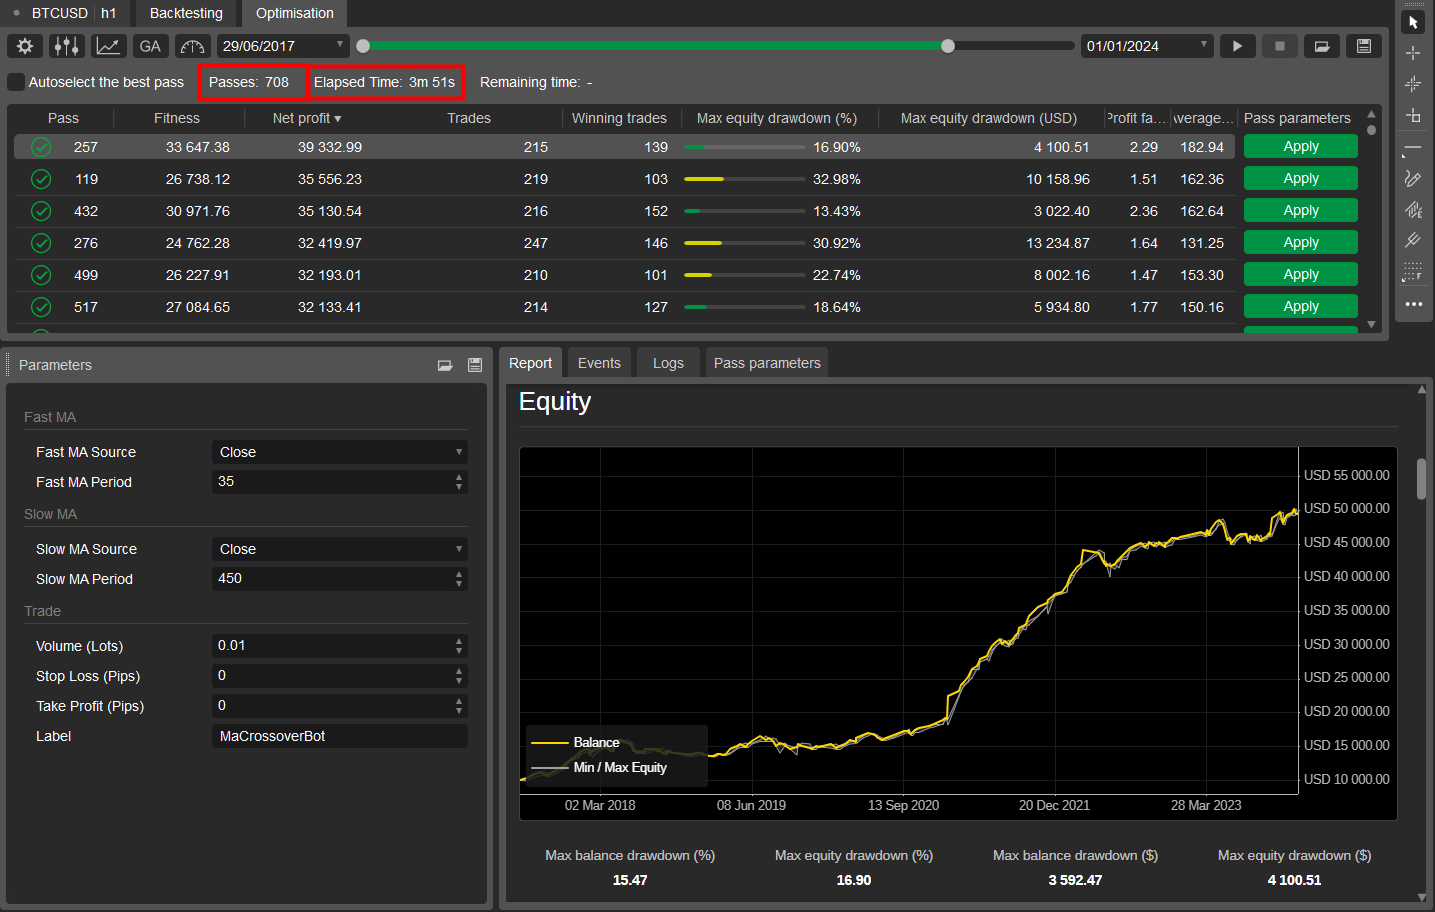

In [17]:
from IPython import display
display.Image("image.png")


Second, the python optimization, results are below the codes

In [18]:
# Stop the notebook here
raise SystemExit("Stop right there because optmization uses a lot of CPU, results are printed below")


def evaluate_parameters(params, data_df, initial_capital, position_size):
    """Helper function to evaluate a single parameter combination"""
    short_period, long_period, sl, tp = params
    
    # Calculate MAs for this combination
    df_ma = calculate_moving_averages(data_df.copy(), short_window=short_period, long_window=long_period)
    df_ma.dropna(inplace=True)
    
    if df_ma.empty:
        return None
        
    short_col = f'SMA{short_period}'
    long_col = f'SMA{long_period}'
    
    trades, final_cap, profit_points = backtest_ma_crossover_strategy(
        df_ma,
        short_sma_col=short_col,
        long_sma_col=long_col,
        initial_capital=initial_capital,
        position_size_fraction=position_size,
        sl_amount=sl,
        tp_amount=tp
    )
    
    if not trades:
        return None
        
    # Calculate metrics
    positions_count = sum(1 for trade in trades if "profit" in trade)
    winning_trades = [trade['profit'] for trade in trades if "profit" in trade and trade['profit'] > 0]
    winrate = len(winning_trades) / positions_count * 100 if positions_count > 0 else 0
    
    # Calculate Sortino ratio
    sortino_ratio = 0
    if profit_points and len(profit_points) > 0:
        sortino_ratio = np.sqrt(252) * np.mean(profit_points) / np.std([p for p in profit_points if p < 0]) if any(p < 0 for p in profit_points) else np.sqrt(252) * np.mean(profit_points)
    
    return {
        'short_sma': short_period,
        'long_sma': long_period,
        'sl': sl,
        'tp': tp,
        'final_capital': final_cap,
        'sortino': sortino_ratio,
        'winrate': winrate
    }

SystemExit: Stop right there because optmization uses a lot of CPU, results are printed below

C:\Users\33668\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [73]:
def optimize_strategy_parameters(data_df, initial_capital=10000, position_size_frac=0.5):
    """
    Optimizes the strategy parameters by testing different combinations of:
    - Short SMA period
    - Long SMA period
    - Stop Loss amount
    - Take Profit amount
    
    Uses parallel processing to speed up the optimization.
    Returns the best performing parameters.
    """
    try:
        from pathos.multiprocessing import ProcessingPool as Pool
    except ImportError:
        print("pathos not installed. Installing pathos for parallel processing...")
        import subprocess
        subprocess.check_call(["pip", "install", "pathos"])
        from pathos.multiprocessing import ProcessingPool as Pool
    
    # Define parameter ranges to test
    short_sma_periods = range(10, 51, 5)  # 10, 15, 20, 25, 30, 35, 40, 45, 50
    long_sma_periods = range(50, 500, 25)  # 50, 75, 100, ..., 475, 500
    sl_amounts = [0, 100, 200, 300]  # Including no stop loss
    tp_amounts = [0, 200, 400, 600]  # Including no take profit
    position_size = position_size_frac
    
    # Generate all valid parameter combinations
    parameter_combinations = [
        (short, long, sl, tp)
        for short in short_sma_periods
        for long in long_sma_periods
        for sl in sl_amounts
        for tp in tp_amounts
        if long > short * 1.5  # Skip invalid combinations
    ]
    
    total_combinations = len(parameter_combinations)
    print(f"\nTesting {total_combinations} parameter combinations using parallel processing...")
    
    # Create a pool of workers
    num_cpus = os.cpu_count()
    pool = Pool(nodes=num_cpus)
    print(f"Using {num_cpus} CPU cores for parallel processing")
    
    # Evaluate all combinations in parallel
    results = []
    try:
        # Create a partial function with fixed arguments
        from functools import partial
        evaluate_partial = partial(evaluate_parameters, 
                                 data_df=data_df, 
                                 initial_capital=initial_capital,
                                 position_size=position_size)
        
        # Map the evaluation function across all parameter combinations
        results = list(filter(None, pool.map(evaluate_partial, parameter_combinations)))
    finally:
        pool.close()
        pool.join()
    
    if not results:
        print("No valid results found from parameter optimization")
        return None
    
    # Find best parameters based on Sortino ratio
    best_params = max(results, key=lambda x: x['sortino'])
    
    print("\n=== Optimization Results ===")
    print(f"Best parameters found:")
    print(f"Short SMA period: {best_params['short_sma']}")
    print(f"Long SMA period: {best_params['long_sma']}")
    print(f"Stop Loss: ${best_params['sl']}")
    print(f"Take Profit: ${best_params['tp']}")
    print(f"Final Capital: ${best_params['final_capital']:.2f}")
    print(f"Sortino Ratio: {best_params['sortino']:.2f}")
    print(f"Win Rate: {best_params['winrate']:.2f}%")
    
    # Sort results by Sortino ratio and display top 5
    print("\nTop 5 Parameter Combinations:")
    sorted_results = sorted(results, key=lambda x: x['sortino'], reverse=True)[:5]
    for i, result in enumerate(sorted_results, 1):
        print(f"\n{i}. Parameters:")
        print(f"   Short SMA: {result['short_sma']}, Long SMA: {result['long_sma']}")
        print(f"   SL: ${result['sl']}, TP: ${result['tp']}")
        print(f"   Final Capital: ${result['final_capital']:.2f}")
        print(f"   Sortino Ratio: {result['sortino']:.2f}")
        print(f"   Win Rate: {result['winrate']:.2f}%")
    
    return best_params

: 

Optimization results : 

Testing 2512 parameter combinations using parallel processing...
Using 12 CPU cores for parallel processing

=== Optimization Results ===
Best parameters found:
Short SMA period: 35
Long SMA period: 450
Stop Loss: $100
Take Profit: $0
Final Capital: $17119.54
Sortino Ratio: 297.33
Win Rate: 14.29%

Top 5 Parameter Combinations:

1. Parameters:
   Short SMA: 35, Long SMA: 450
   SL: $100, TP: $0
   Final Capital: $17119.54
   Sortino Ratio: 297.33
   Win Rate: 14.29%

2. Parameters:
   Short SMA: 25, Long SMA: 475
   SL: $100, TP: $0
   Final Capital: $19769.65
   Sortino Ratio: 296.62
   Win Rate: 12.50%

3. Parameters:
   Short SMA: 35, Long SMA: 475
   SL: $100, TP: $0
   Final Capital: $15319.96
   Sortino Ratio: 252.74
   Win Rate: 10.45%

4. Parameters:
   Short SMA: 25, Long SMA: 375
   SL: $100, TP: $0
   Final Capital: $16850.05
   Sortino Ratio: 236.34
   Win Rate: 8.60%

5. Parameters:
   Short SMA: 30, Long SMA: 375
   SL: $100, TP: $0
   Final Capital: $18064.74
   Sortino Ratio: 232.16
   Win Rate: 11.49%